In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import shutil
import seaborn as sns
import cv2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils import class_weight
from tensorflow.keras.applications.efficientnet import preprocess_input
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, recall_score, accuracy_score, auc
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [6]:
# paths for originaldataset directories
data_dir = r'Dataset - Copy'  
tb_dir = os.path.join(data_dir, 'Tuberculosis')
normal_dir = os.path.join(data_dir, 'Normal')

# Get all file paths
tb_files = [os.path.join(tb_dir, f) for f in os.listdir(tb_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
normal_files = [os.path.join(normal_dir, f) for f in os.listdir(normal_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Create labels
tb_labels = [1] * len(tb_files)
normal_labels = [0] * len(normal_files)

# Combine
all_files = tb_files + normal_files
all_labels = tb_labels + normal_labels

# Split into train (70%), validation (15%), test (15%)
train_files, temp_files, train_labels, temp_labels = train_test_split(
    all_files, all_labels, test_size=0.3, random_state=42, stratify=all_labels
)

val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

# Create folder structure
train_dir = os.path.join(data_dir, 'Train')
val_dir = os.path.join(data_dir, 'Validation')
test_dir = os.path.join(data_dir, 'Test')

for split_dir in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(split_dir, 'Tuberculosis'), exist_ok=True)
    os.makedirs(os.path.join(split_dir, 'Normal'), exist_ok=True)

# Copy files to respective folders
def copy_files(file_list, label_list, destination_dir):
    for file_path, label in zip(file_list, label_list):
        class_name = 'Tuberculosis' if label == 1 else 'Normal'
        dest_path = os.path.join(destination_dir, class_name, os.path.basename(file_path))
        shutil.copy2(file_path, dest_path)

copy_files(train_files, train_labels, train_dir)
copy_files(val_files, val_labels, val_dir)
copy_files(test_files, test_labels, test_dir)

print(f"Created Train folder with {len(train_files)} images")
print(f"Created Validation folder with {len(val_files)} images")
print(f"Created Test folder with {len(test_files)} images")

Created Train folder with 3500 images
Created Validation folder with 750 images
Created Test folder with 750 images


In [7]:
# Data set for model
train_dir = r'Dataset - Copy/Train'
val_dir = r'Dataset - Copy/Validation'
test_dir = r'Dataset - Copy/Test'

In [8]:
# 1. Define the Combined Preprocessing Function
def mask_and_preprocess(img):
    # --- A. CUSTOM MASKING  ---
    # Ensure image is a writable array
    img = np.array(img).copy()
    height, width, _ = img.shape
    
    # Define mask size (30% of image)
    mask_h = int(height * 0.25) 
    mask_w = int(width * 0.25)
    
    # 1. Sensor Pojok Kiri Atas
    img[0:mask_h, 0:mask_w, :] = 0.0
    
    # 2. Sensor Pojok Kanan Atas
    img[0:mask_h, width-mask_w:width, :] = 0.0
    
    # --- B. EFFICIENTNET PREPROCESSING ---
    # This scales the pixel values correctly for the model
    return preprocess_input(img)

# 2. Setup Generators
IMG_SIZE = (224, 224) # Keep 224 for EfficientNetB0 (or 320 if you rebuilt the model)
BATCH_SIZE = 32

# Generator TRAINING
train_datagen = ImageDataGenerator(
    rotation_range=5,      
    zoom_range=0.1,
    width_shift_range=0.05, 
    height_shift_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=mask_and_preprocess # <--- SENSOR AKTIF + Preprocess
)

# Generator VALIDATION & TEST
val_test_datagen = ImageDataGenerator(
    preprocessing_function=mask_and_preprocess # <--- SENSOR AKTIF + Preprocess
)

# 3. Load Data from Directories (Connecting to your folders)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 3500 images belonging to 2 classes.
Found 750 images belonging to 2 classes.
Found 750 images belonging to 2 classes.



--- SAMPLE: NORMAL ---


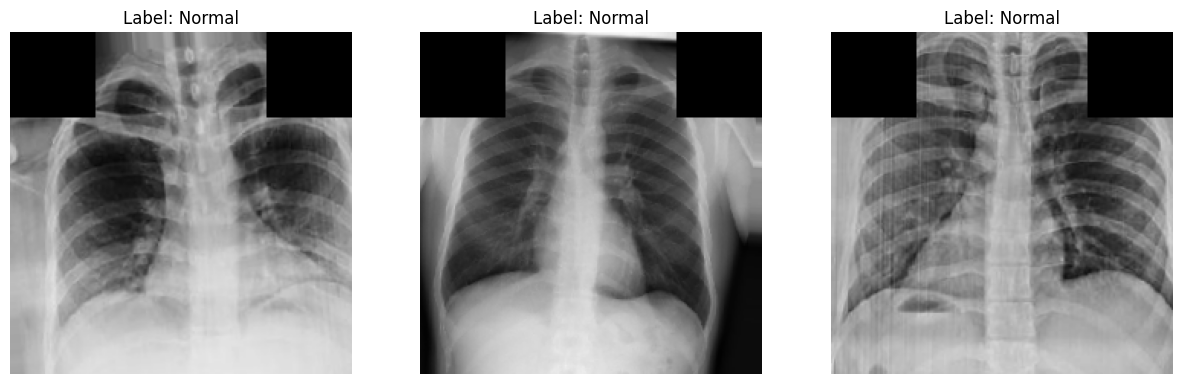


--- SAMPLE: TUBERCULOSIS ---


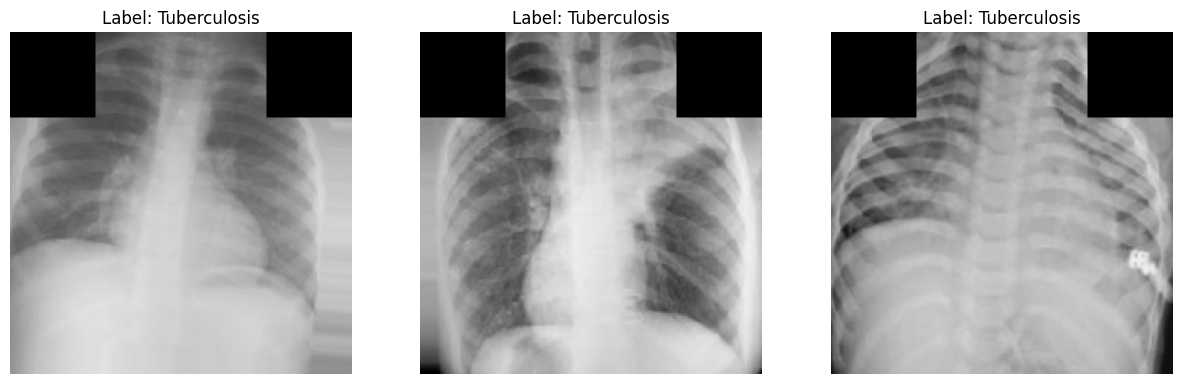

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Get a batch of images
x_batch, y_batch = next(train_generator)

# 2. Get the label names (flip the dictionary)
# Result: {0: 'Normal', 1: 'Tuberculosis'}
label_map = {v: k for k, v in train_generator.class_indices.items()}

# 3. Separate images by class so we can show specific examples
normal_images = [x_batch[i] for i in range(len(y_batch)) if y_batch[i] == 0]
tb_images = [x_batch[i] for i in range(len(y_batch)) if y_batch[i] == 1]

# 4. Plotting Function
def show_samples(images, title, count=3):
    plt.figure(figsize=(15, 5))
    # Handle case if we have fewer images than requested
    limit = min(len(images), count)
    
    for i in range(limit):
        ax = plt.subplot(1, count, i + 1)
        img = images[i].astype('uint8') # Convert for display
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    plt.show()

# 5. Show 3 Normal Images
if len(normal_images) > 0:
    print("\n--- SAMPLE: NORMAL ---")
    show_samples(normal_images, "Label: Normal")
else:
    print("No Normal images in this random batch. Run the cell again.")

# 6. Show 3 Tuberculosis Images
if len(tb_images) > 0:
    print("\n--- SAMPLE: TUBERCULOSIS ---")
    show_samples(tb_images, "Label: Tuberculosis")
else:
    print("No TB images in this random batch. Run the cell again.")

In [10]:
def build_model():
    # 1. Define Input Shape (EfficientNetB0 default is 224x224)
    # Ensure this matches the image_size you defined in Cell 4
    input_shape = (224, 224, 3) 

    # 2. Load the Pre-trained Base Model
    # include_top=False: Removes the final 1000-class layer (ImageNet head)
    # weights='imagenet': Loads the pre-trained knowledge
    model = EfficientNetB0(
        weights='imagenet', 
        include_top=False, 
        input_shape=input_shape
    )

    # 3. Freeze the Base Model
    # We set trainable=False so we don't destroy the pre-trained patterns 
    # while our new "head" layers are initialized with random weights.
    model.trainable = False

    # 4. Build the Classifiction Head (Matching DenseNet approach)
    x = model.output
    
    # Global Average Pooling: Converts the 3D feature map into a 1D vector
    x = GlobalAveragePooling2D()(x)
    
    # Output Layer: 1 neuron with sigmoid activation for Binary Classification
    # (0 = Normal, 1 = Tuberculosis)
    output = Dense(1, activation='sigmoid')(x)

    # 5. Assemble the final model
    model = Model(inputs=model.input, outputs=output)
    
    return model

# Instantiate the model
model = build_model()

# Verify the structure
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [11]:
loss_fn = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=loss_fn,  # <--- Use the smoothed loss here
    metrics=["accuracy", "AUC"]
)

In [12]:
# 1. Define Callbacks
checkpoint = ModelCheckpoint(
    'v6_efficientnetb0_tb_best.keras', 
    monitor='val_loss',      
    verbose=1, 
    save_best_only=True, 
    mode='min'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=3, 
    verbose=1, 
    min_lr=1e-6
)

early_stop = EarlyStopping(
    monitor='val_loss',         
    patience=5,                 
    verbose=1,
    restore_best_weights=True,  
    mode='min'                  
)

# 2. Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=100,  
    callbacks=[checkpoint, reduce_lr, early_stop]
)

Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.6589 - accuracy: 0.6235 - loss: 0.6638
Epoch 1: val_loss improved from None to 0.51760, saving model to v6_efficientnetb0_tb_best.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - AUC: 0.7889 - accuracy: 0.7214 - loss: 0.6177 - val_AUC: 0.9400 - val_accuracy: 0.8533 - val_loss: 0.5176 - learning_rate: 1.0000e-04
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9380 - accuracy: 0.8605 - loss: 0.5124
Epoch 2: val_loss improved from 0.51760 to 0.42778, saving model to v6_efficientnetb0_tb_best.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - AUC: 0.9503 - accuracy: 0.8746 - loss: 0.4902 - val_AUC: 0.9758 - val_accuracy: 0.9080 - val_loss: 0.4278 - learning_rate: 1.0000e-04
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9631 - accuracy: 0.8864 - loss: 0.4436
Epoch 3: val_loss improved from 0.42778 to 0.37938, saving model to v6_efficientnetb0_tb_best.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - AUC

In [13]:
# --- STEP 2: FINE TUNING STRATEGY ---


# 1. Unfreeze Base Model secara parsial
model.trainable = True

# 2. Aturan Emas: BEKUKAN BatchNormalization
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# 3. (Opsional) Bekukan layer awal, latih 30 layer terakhir saja
# Semakin sedikit data, semakin banyak yang harus dibekukan
fine_tune_at = len(model.layers) - 30
for layer in model.layers[:fine_tune_at]:
    layer.trainable = False

# 4. Compile dengan Learning Rate SANGAT KECIL
# Gunakan 1e-5 (0.00001) biar tidak merusak bobot yang sudah ada
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
    metrics=["accuracy", "AUC"]
)

# 5. Callbacks Khusus Fine Tuning (Sabar dikit)
ft_callbacks = [
    EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True, 
        verbose=1),
    
    ModelCheckpoint(
        'v6_finetuned_best.keras', 
        monitor='val_loss', 
        save_best_only=True, 
        mode='max', 
        verbose=1
    )    
]

# 6. Train Lagi
history_fine = model.fit(
    train_generator,
    epochs=20, 
    validation_data=val_generator,
    callbacks=ft_callbacks
)

Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.9985 - accuracy: 0.9842 - loss: 0.2590
Epoch 1: val_loss improved from None to 0.26820, saving model to v6_finetuned_best.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - AUC: 0.9986 - accuracy: 0.9831 - loss: 0.2587 - val_AUC: 0.9991 - val_accuracy: 0.9693 - val_loss: 0.2682
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9993 - accuracy: 0.9855 - loss: 0.2543
Epoch 2: val_loss improved from 0.26820 to 0.26833, saving model to v6_finetuned_best.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - AUC: 0.9990 - accuracy: 0.9849 - loss: 0.2565 - val_AUC: 0.9991 - val_accuracy: 0.9680 - val_loss: 0.2683
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9990 - accuracy: 0.9839 - loss: 0.2549
Epoch 3: val_loss improved from 0.26833 to 0.26846, saving model to v6_finetuned_best.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - AUC: 0.9984 - accuracy: 0.9809 - loss: 0.2587 - val_AUC: 0.9991 - val_accuracy: 0.9680

In [14]:
model.save('v6_efficientnetb0_tb_best.keras')
print("Model saved successfully as 'v6_efficientnetb0_tb_best.keras'")

Model saved successfully as 'v6_efficientnetb0_tb_best.keras'


24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 307ms/step
--- Results with Threshold 0.5 ---
              precision    recall  f1-score   support

      Normal       0.93      1.00      0.96       375
Tuberculosis       1.00      0.92      0.96       375

    accuracy                           0.96       750
   macro avg       0.96      0.96      0.96       750
weighted avg       0.96      0.96      0.96       750



<Axes: >

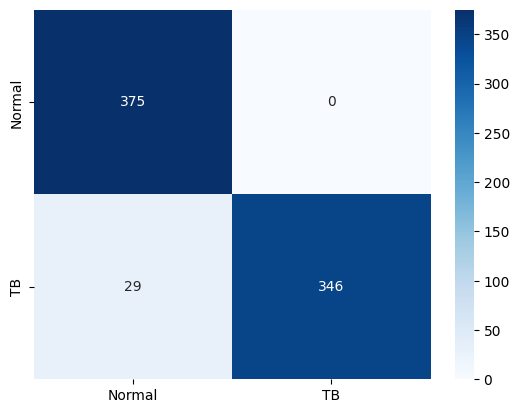

In [30]:
# Optimize Threshold
from sklearn.metrics import classification_report, confusion_matrix

# Get the raw probabilities again (not the 0/1 labels)
y_pred_probs = model.predict(test_generator)

# Input Treshold
new_threshold = 0.5
y_pred_new = (y_pred_probs > new_threshold).astype(int)

print(f"--- Results with Threshold {new_threshold} ---")
print(classification_report(test_generator.classes, y_pred_new, target_names=['Normal', 'Tuberculosis']))

# 2. Make Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred_new)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'TB'], yticklabels=['Normal', 'TB'])

Checking image path: Image For Testing/Tuberculosis - Mixed/TB.3.jpg
Result: TUBERCULOSIS (94.83%)


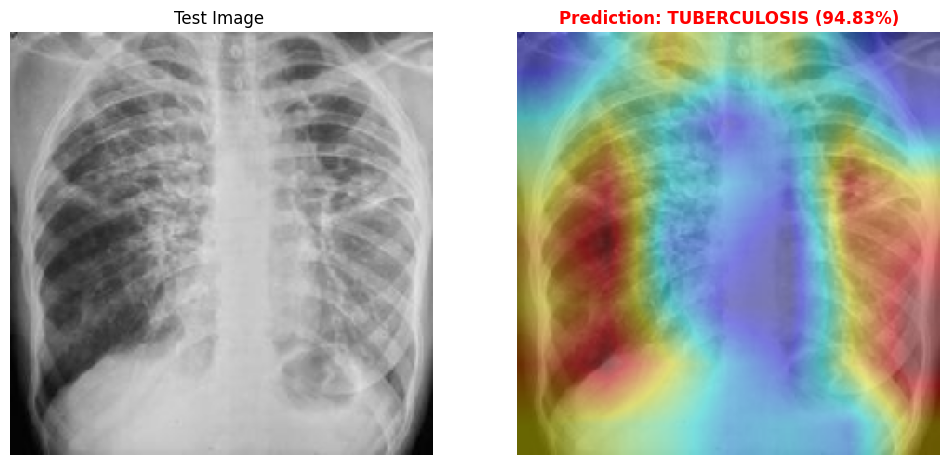

In [ ]:
# --- 1. CONFIGURATION ---
MODEL_PATH = 'v6_efficientnetb0_tb_best.keras' 
IMG_SIZE = (224, 224) 
LAST_CONV_LAYER = 'top_activation' # Change to 'block6a_expand_activation' for smoother heatmap
THRESHOLD = 0.5

# --- 2. GRAD-CAM FUNCTION ---
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# --- 3. MAIN EXECUTION ---

# A. Load Image
target_img_path = 'Image For Testing/Tuberculosis - Mixed/TB.3.jpg' 
print(f"Checking image path: {target_img_path}")

# B. Load Model
model = load_model(MODEL_PATH, compile=False)
model.layers[-1].activation = None 

# C. Process Image (SPLIT LOGIC: AI vs HUMAN)
img = load_img(target_img_path, target_size=IMG_SIZE)
original_array = img_to_array(img) # This is the clean/pure array

# --- 1. Prepare Masked Version (Strictly for AI) ---
masked_array = original_array.copy() # Copy it so we don't mess up the original
h, w, _ = masked_array.shape
mask_h, mask_w = int(h * 0.30), int(w * 0.30) # 30% Masking

# Black out corners ONLY on the masked_array
masked_array[0:mask_h, 0:mask_w, :] = 0.0 
masked_array[0:mask_h, w-mask_w:w, :] = 0.0 

# --- 2. Prepare Input Tensor (AI consumes the Masked version) ---
img_tensor = np.expand_dims(masked_array, axis=0)
img_tensor = preprocess_input(img_tensor)

# --- 3. Prepare Display Image (Human sees the Clean version) ---
img_display = original_array.astype('uint8') 

# --- PREDICTION (AI predicts based on the masked image) ---
preds = model.predict(img_tensor, verbose=0)
raw_score = tf.nn.sigmoid(preds[0][0]).numpy()

if raw_score > THRESHOLD:
    label = "TUBERCULOSIS"
    confidence = raw_score * 100
    text_color = 'red'
else:
    label = "NORMAL"
    confidence = (1 - raw_score) * 100
    text_color = 'green'

print(f"Result: {label} ({confidence:.2f}%)")

# D. Generate Heatmap (Based on the masked tensor)
heatmap = make_gradcam_heatmap(img_tensor, model, LAST_CONV_LAYER)

# E. Overlay (Paste the Heatmap onto the CLEAN Image)
heatmap_resized = cv2.resize(heatmap, IMG_SIZE)
heatmap_uint8 = np.uint8(255 * heatmap_resized)
heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

# Key Step: Heatmap is added to 'img_display' (the clean one)
superimposed_img = cv2.addWeighted(img_display, 0.6, heatmap_color, 0.4, 0)

# F. Plot/Display
plt.figure(figsize=(12, 6))

# Left Image: Show the original image
plt.subplot(1, 2, 1)
plt.imshow(img_display)
plt.title("Test Image ")
plt.axis('off')

# Right Image: Overlay Heatmap on top of clean image
plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title(f"Prediction: {label} ({confidence:.2f}%)", 
          color=text_color, fontsize=12, fontweight='bold')
plt.axis('off')

plt.show()